In [1]:
import json
import pandas as pd

from utils.plotter import plot_gantt_jobs
from utils.plotter import plot_gantt_machines
from utils.simple_priority_heuristics import schedule_spt

from utils.checker import check_machine_conflicts
from utils.checker import check_job_machine_sequence

In [2]:
import numpy as np
import random

In [3]:
# Datei laden
with open("data/jobshop_instances_named.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
job_order = sorted(instance, key=lambda x: int(x.split()[1]))  # "job 0", "job 1", ...
matrix = [instance[job_name] for job_name in job_order]
for job in matrix:
    print(job)

[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]


In [4]:
def get_all_machine_ids(job_shop_matrix):
    machines = set()
    for job in job_shop_matrix:
        for operation in job:
            machines.add(operation[0])
    return machines

## I) Mittlere Zwischenankunftszeit t_a

### 1. Vektor der Bearbeitungszeiten auf der Engpassmaschine

#### a) Bestimmung der Engpassmaschine (7.12)

$$
m_{\text{max}} = \arg\max_{m \in M} T_m
$$

In [9]:
# Initialisiere Dictionary für alle Maschinen (0–9)
machine_usage = {machine_id: 0 for machine_id in get_all_machine_ids(matrix)}

# Summiere Bearbeitungszeiten je Maschine
for job in matrix:
    for machine, duration in job:
        machine_usage[machine] += duration

# Ausgabe
print("Bearbeitungszeit pro Maschine:")
for machine, total_time in sorted(machine_usage.items()):
    print(f"Maschine {machine}: {total_time} Minuten")

Bearbeitungszeit pro Maschine:
Maschine 0: 493 Minuten
Maschine 1: 548 Minuten
Maschine 2: 556 Minuten
Maschine 3: 631 Minuten
Maschine 4: 534 Minuten
Maschine 5: 416 Minuten
Maschine 6: 491 Minuten
Maschine 7: 499 Minuten
Maschine 8: 531 Minuten
Maschine 9: 410 Minuten


In [10]:
# print(max(machine_usage.values()))
engpassmaschine = max(machine_usage, key=machine_usage.get)

engpassmaschine

3

#### b) Vektor der Bearbeitungszeiten auf der Engpassmaschine erstellen

In [12]:
def get_vec_t_b_mmax(engpassmaschine, job_shop_matrix):
    vec_t_b_mmax = []
    for job in job_shop_matrix:
        duration = next((d for m, d in job if m == engpassmaschine), 0)
        vec_t_b_mmax.append(duration)
    return vec_t_b_mmax


In [13]:
vec_t_b_mmax = get_vec_t_b_mmax(engpassmaschine, matrix)
vec_t_b_mmax

[36, 69, 39, 98, 26, 95, 61, 79, 76, 52]

### 2. Job-Wahrscheinlichkeiten

In [15]:
# Gleichverteilt 
n_jobs = len(matrix)
p = [1 / n_jobs] * n_jobs
p

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

### 3. Zielauslastung 

In [17]:
u_b_mmax = 0.9  # 90 %

### 4. Berechne die mittlere Zwischenankunftszeit t_a nach Formel (7.16)

$$
t_a = \frac{\vec{p}^T \cdot \vec{t}_{b, m_{\text{max}}}}{u_{b, m_{\text{max}}}}
$$

- $t_a$: mittlere Zwischenankunftszeit  
- $\vec{p}$: Vektor der Wahrscheinlichkeiten der Arbeitspläne (bzw. Jobs)  
- $\vec{t}_{b, m_{\text{max}}}$: Vektor der Bearbeitungszeiten auf der Engpassmaschine  
- $u_{b, m_{\text{max}}}$: gewünschte Auslastung der Engpassmaschine


In [20]:
t_a = sum(p[i] * vec_t_b_mmax[i] for i in range(n_jobs)) / u_b_mmax
t_a = np.round(t_a, 2)
print(f"Mittlere Zwischenankuftszeit: ~{t_a} Zeiteinheiten")

Mittlere Zwischenankuftszeit: ~70.11 Zeiteinheiten


## II) Ankunftszeiten

In [22]:
# Anzahl der Aufträge (Jobs)
n_jobs = len(matrix)


# Generierung eine zufällige Job-Reihenfolge
np.random.seed(12)
job_sequence = list(np.random.permutation(n_jobs))  # liefert direkt permutierte Liste
job_sequence

[5, 8, 7, 0, 4, 9, 3, 2, 1, 6]

In [23]:
# Generierung exponentiell verteilte Zwischenankunftszeiten mit Mittelwert t_a
np.random.seed(123)
interarrival_times = np.random.exponential(scale=t_a, size=n_jobs)

# Berechne absolute Ankunftszeiten
arrival_times = np.cumsum(interarrival_times)
arrival_times = np.round(arrival_times, 2)


In [24]:
# Kombiniere Reihenfolge und Zeitpunkte
job_arrivals = list(zip(job_sequence, arrival_times))

# Ausgabe als DataFrame
df_arrivals = pd.DataFrame(job_arrivals, columns=["Job-ID", "Ankunftszeit (Minuten)"])
df_arrivals = df_arrivals.sort_values(by="Ankunftszeit (Minuten)").reset_index(drop=True)
df_arrivals

,Job-ID,Ankunftszeit (Minuten)
0,5,83.59
1,8,107.22
2,7,125.26
3,0,181.45
4,4,270.56
5,9,309.13
6,3,586.13
7,2,667.09
8,1,713.06
9,6,747.96


## III) Scheduling

### a) First Come First Serve

In [27]:
# FCFS mit Ankunftszeiten berücksichtigen
def schedule_fcfs_with_arrivals(matrix, arrival_df):
    num_jobs = len(matrix)
    
    # Ankunftszeiten als Dict
    arrival_times = arrival_df.set_index("Job-ID")["Ankunftszeit (Minuten)"].to_dict()
    
    # Initialisierungen
    job_ready = [arrival_times[job_id] for job_id in range(num_jobs)]
    machine_ready = {}
    schedule = []

    # Jobs nach Ankunftszeit sortieren
    sorted_jobs = arrival_df.sort_values(by="Ankunftszeit (Minuten)")["Job-ID"].tolist()

    # FCFS: bearbeite Jobs der Reihe nach
    for job_id in sorted_jobs:
        for machine, duration in matrix[job_id]:
            start = max(job_ready[job_id], machine_ready.get(machine, 0))
            end = start + duration

            schedule.append({
                'Job': f'Job {job_id}',
                'Machine': f'M{machine}',
                'Start': start,
                'Duration': duration,
                'End': end
            })

            job_ready[job_id] = end
            machine_ready[machine] = end

    return pd.DataFrame(schedule)


In [28]:
df_fcfs = schedule_fcfs_with_arrivals(matrix, df_arrivals)
df_fcfs

,Job,Machine,Start,Duration,End
0,Job 5,M2,83.59,84,167.59
1,Job 5,M1,167.59,2,169.59
2,Job 5,M5,169.59,52,221.59
3,Job 5,M3,221.59,95,316.59
4,Job 5,M8,316.59,48,364.59
...,...,...,...,...,...
95,Job 6,M5,3275.59,21,3296.59
96,Job 6,M9,3296.59,32,3328.59
97,Job 6,M8,3328.59,89,3417.59
98,Job 6,M7,3417.59,30,3447.59


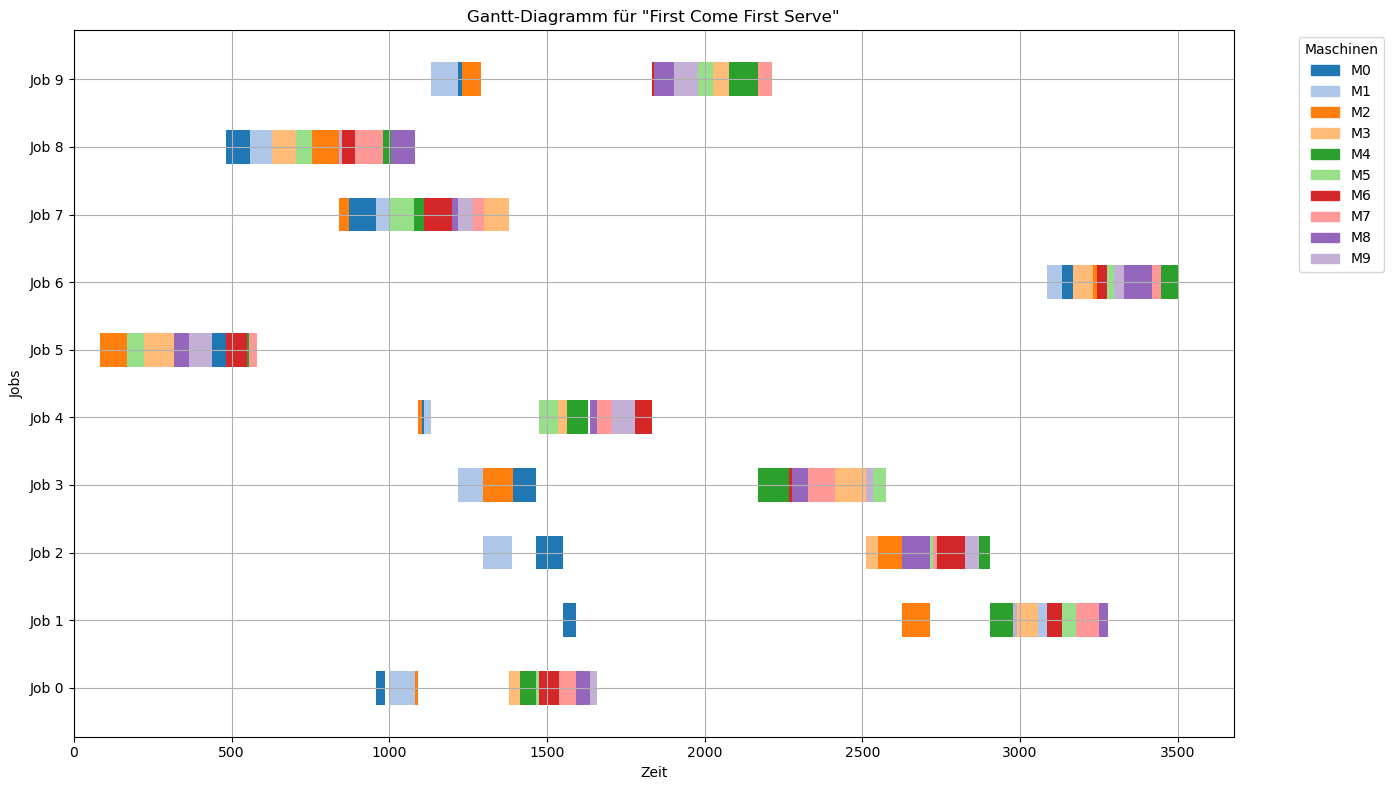

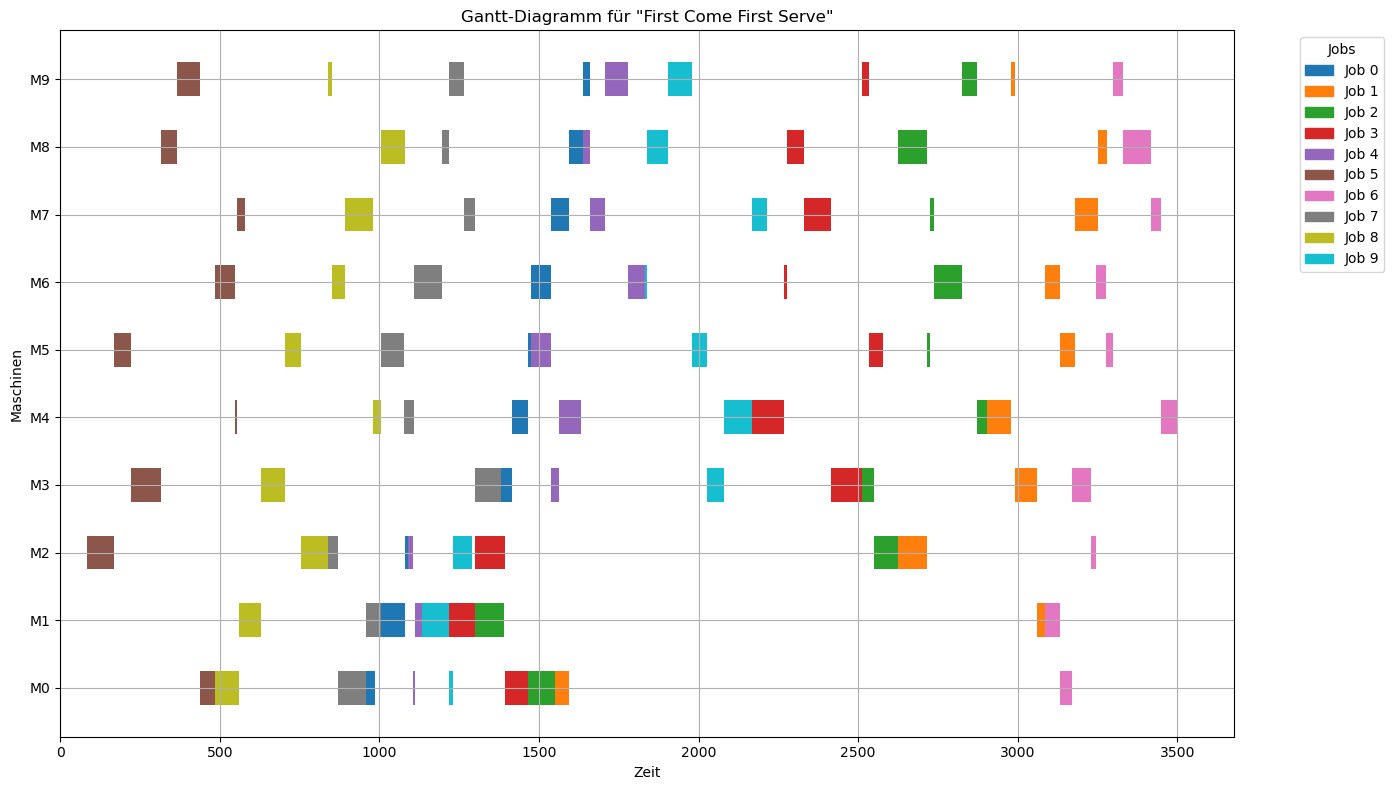

In [29]:
category = "First Come First Serve"

plot_gantt_jobs(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))
plot_gantt_machines(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))

In [30]:
check_machine_conflicts(df_fcfs)
check_job_machine_sequence(df_fcfs, matrix)

Gefundene Konflikte auf Maschinen: 0

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0


True

### b) HiGHS

In [32]:
import pulp
import pandas as pd

# Anzahl Jobs und Maschinen
num_jobs = len(matrix)
num_machines = len({op[0] for job in matrix for op in job})

# LP-Problem: Minimierung des Makespans
prob = pulp.LpProblem("JobShop_Optimal_HiGHS", pulp.LpMinimize)

# Variablen: Startzeiten
starts = {
    (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
    for j in range(num_jobs) for o in range(len(matrix[j]))
}

# Makespan-Variable
makespan = pulp.LpVariable("makespan", lowBound=0, cat="Continuous")

# Ziel: Minimierung des Makespans
prob += makespan

# Ankunftszeiten aus df_arrivals (DataFrame mit "Job-ID" und "Ankunftszeit (Minuten)")
arrival_times_dict = df_arrivals.set_index("Job-ID")["Ankunftszeit (Minuten)"].to_dict()

# Technologische Reihenfolge (innerhalb eines Jobs) inkl. Ankunftszeit
for j in range(num_jobs):
    prob += starts[(j, 0)] >= arrival_times_dict[j]  # Berücksichtige Ankunft
    for o in range(1, len(matrix[j])):
        d_prev = matrix[j][o - 1][1]
        prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

# Maschinenkonflikte (Disjunktivbedingungen)
bigM = 1e5
for m in range(num_machines):
    ops = [(j, o, d) for j in range(num_jobs)
           for o, (mach, d) in enumerate(matrix[j]) if mach == m]
    for i in range(len(ops)):
        j1, o1, d1 = ops[i]
        for j2, o2, d2 in ops[i + 1:]:
            if j1 != j2:
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 <= starts[(j1, o1)] + bigM * y

# Makespan-Bedingung: späteste Endzeit einer Operation
for j in range(num_jobs):
    last_op = len(matrix[j]) - 1
    prob += makespan >= starts[(j, last_op)] + matrix[j][last_op][1]

# Solver starten (HiGHS)
solver = pulp.HiGHS_CMD(msg=True, timeLimit=3600*5)
prob.solve(solver)

# Ergebnis extrahieren
schedule_data = []
for (j, o), var in sorted(starts.items()):
    start = var.varValue
    if start is not None:
        machine, duration = matrix[j][o]
        end = start + duration
        schedule_data.append({
            "Job": f"Job {j}",
            "Machine": f"M{machine}",
            "Start": round(start, 1),
            "Duration": duration,
            "End": round(end, 1)
        })

# Zeitplan als DataFrame
df_schedule_highs = pd.DataFrame(schedule_data)
print(f"Optimaler Makespan: {round(pulp.value(makespan), 2)} Zeiteinheiten")

Optimaler Makespan: 1346.13 Zeiteinheiten


In [33]:
df_schedule_highs

,Job,Machine,Start,Duration,End
0,Job 0,M0,410.6,29,439.6
1,Job 0,M1,443.6,78,521.6
2,Job 0,M2,658.1,9,667.1
3,Job 0,M3,728.1,36,764.1
4,Job 0,M4,808.2,49,857.2
...,...,...,...,...,...
95,Job 9,M9,543.2,76,619.2
96,Job 9,M5,619.2,47,666.2
97,Job 9,M3,666.2,52,718.2
98,Job 9,M4,718.2,90,808.2


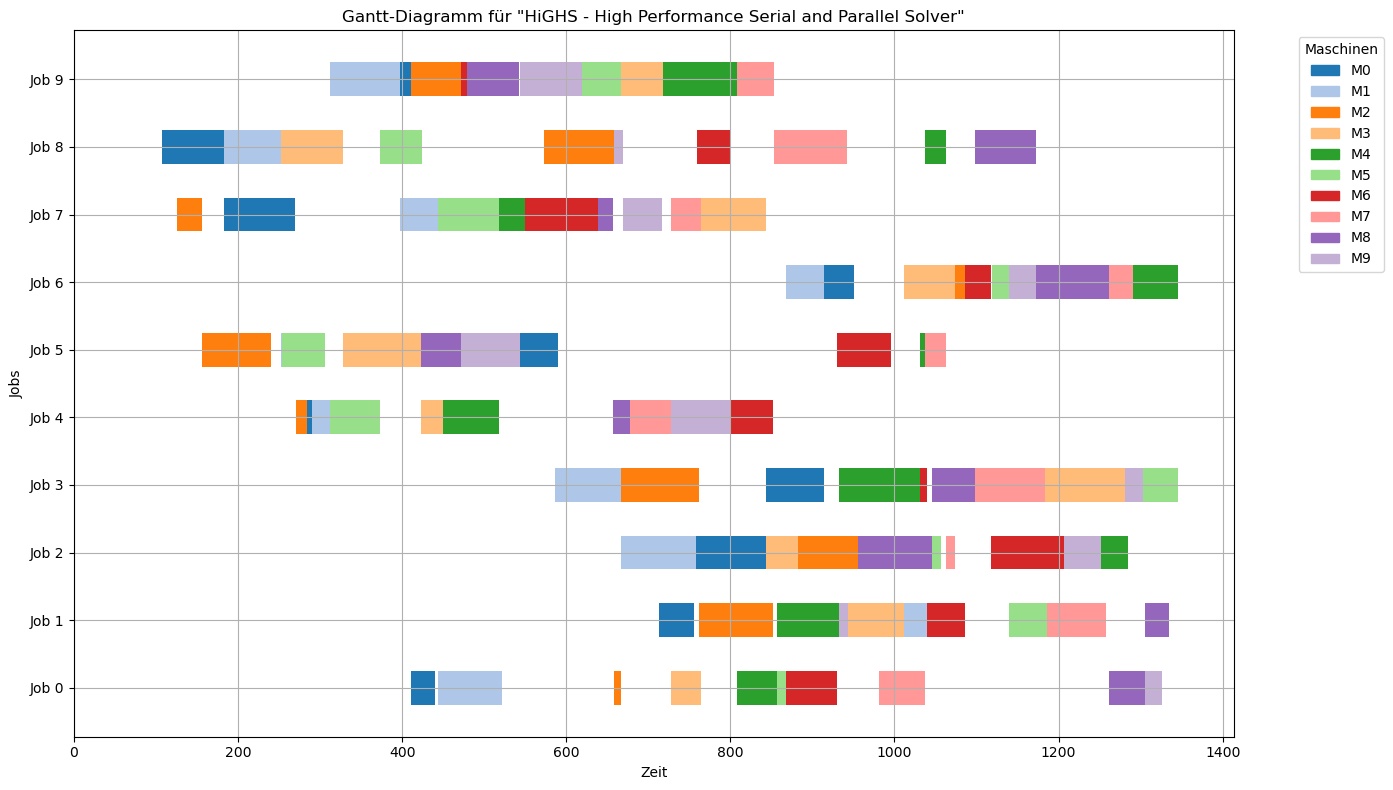

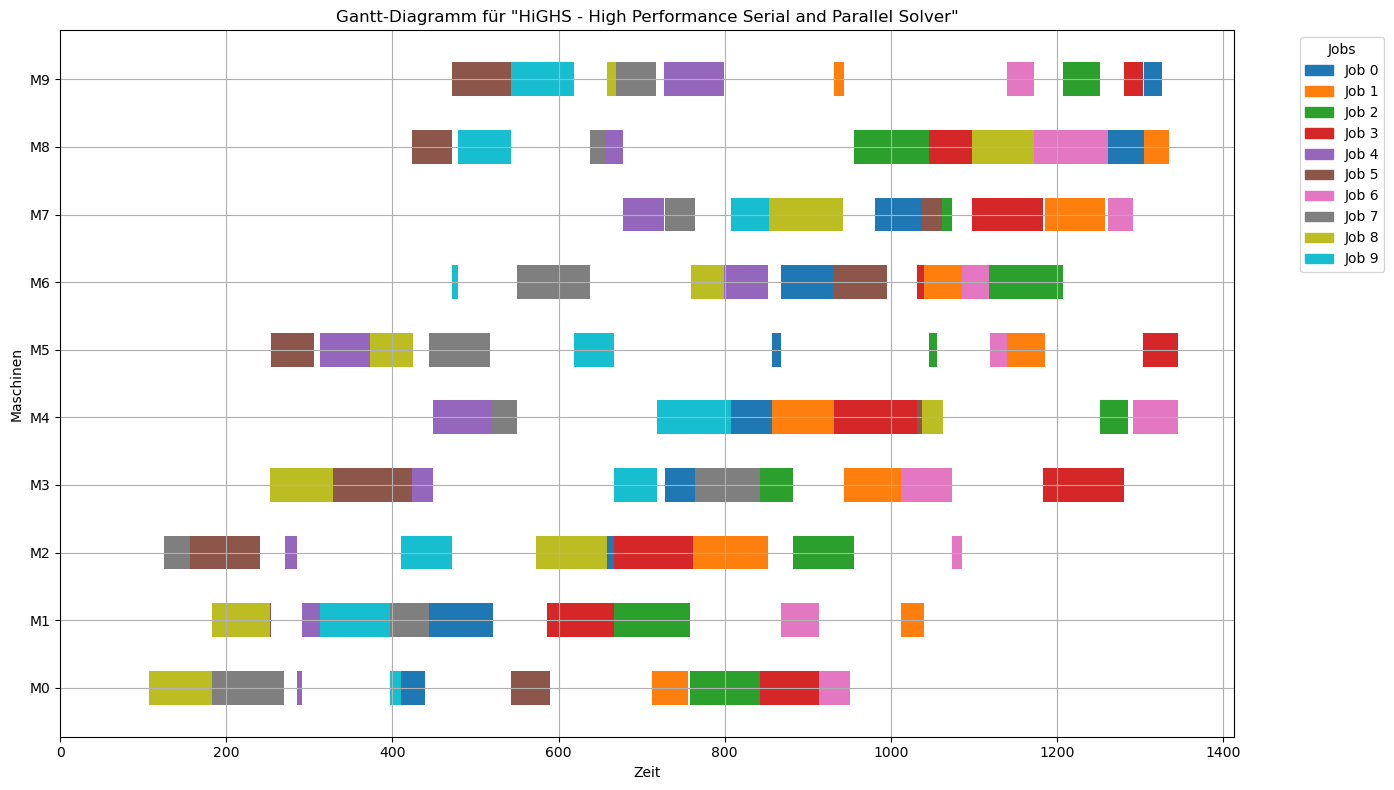

In [34]:
df = df_schedule_highs
category = "HiGHS - High Performance Serial and Parallel Solver"

plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category))
plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category))

In [35]:
check_machine_conflicts(df_schedule_highs)
check_job_machine_sequence(df_schedule_highs, matrix)

Gefundene Konflikte auf Maschinen: 0

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0


True

### mittlere Ankunftsrate λ 

In [71]:
lamda = 1 / t_a
lamda
print(f"{np.round(lamda, 4)} pro Minute (Zeiteinheit)")
print(f"{np.round(lamda*60, 4)} pro Stunde")

0.0143 pro Minute (Zeiteinheit)
0.8558 pro Stunde
